# Perbandingan 13 Model LSTM untuk Prediksi Curah Hujan

Notebook ini membandingkan performa 13 model LSTM yang sudah ditraining tanpa perlu training ulang.

**Model yang dibandingkan:**
1. Baseline (Adam, lr=0.001, bs=64)
2. Deep Architecture (128-64-32)
3. High Dropout (0.5)
4. High LR (Adam, lr=0.01)
5. Large Batch (bs=128)
6. Long Sequence (60 days)
7. Low LR (Adam, lr=0.0001)
8. No Dropout
9. RMSprop Optimizer
10. SGD Optimizer
11. Short Sequence (15 days)
12. Simple Architecture (32-16-8)
13. Small Batch (bs=32)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import load_model
import calendar
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


## 2. Konfigurasi

In [2]:
# Path dataset
DATASET_PATH = ""

# Daftar semua model
MODEL_FILES = [
    'exp_baseline_(adam,_lr=0.001,_bs=64).h5',
    'exp_deep_architecture_(128-64-32).h5',
    'exp_high_dropout_(0.5).h5',
    'exp_high_lr_(adam,_lr=0.01).h5',
    'exp_large_batch_(bs=128).h5',
    'exp_long_sequence_(60_days).h5',
    'exp_low_lr_(adam,_lr=0.0001).h5',
    'exp_no_dropout.h5',
    'exp_rmsprop_optimizer.h5',
    'exp_sgd_optimizer.h5',
    'exp_short_sequence_(15_days).h5',
    'exp_simple_architecture_(32-16-8).h5',
    'exp_small_batch_(bs=32).h5'
]

MODEL_NAMES = [
    'Baseline',
    'Deep Arch',
    'High Dropout',
    'High LR',
    'Large Batch',
    'Long Seq (60d)',
    'Low LR',
    'No Dropout',
    'RMSprop',
    'SGD',
    'Short Seq (15d)',
    'Simple Arch',
    'Small Batch'
]

print(f"Total models to compare: {len(MODEL_FILES)}")

Total models to compare: 13


## 3. Load dan Preprocess Data

In [3]:
def load_and_preprocess_data():
    """Load dan preprocess data"""
    print("Loading dataset...")
    data = pd.read_csv(DATASET_PATH + 'rainfall in india 1901-2015.csv')
    print(f"Dataset shape: {data.shape}")
    
    monthly_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                    'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    
    # Encode subdivision
    encoder = LabelEncoder()
    data['SUB_ID'] = encoder.fit_transform(data['SUBDIVISION'])
    
    # Filter dan preprocess
    data_filtered = data[['SUBDIVISION', 'SUB_ID', 'YEAR'] + monthly_cols]
    data_filtered = data_filtered.fillna(method='ffill').fillna(method='bfill')
    
    # Convert ke daily data
    daily_data = []
    subdivisions = data_filtered['SUBDIVISION'].unique()
    
    print(f"Converting to daily data for {len(subdivisions)} subdivisions...")
    for sub in subdivisions:
        sub_df = data_filtered[data_filtered['SUBDIVISION'] == sub]
        sub_id = sub_df['SUB_ID'].iloc[0]
        for _, row in sub_df.iterrows():
            year = int(row['YEAR'])
            for month_idx, month in enumerate(monthly_cols):
                month_num = month_idx + 1
                rainfall = row[month]
                days_in_month = calendar.monthrange(year, month_num)[1]
                daily_rainfall = rainfall / days_in_month
                for day in range(1, days_in_month + 1):
                    date = pd.Timestamp(year=year, month=month_num, day=day)
                    daily_data.append({
                        'SUBDIVISION': sub,
                        'SUB_ID': sub_id,
                        'date': date,
                        'rainfall': daily_rainfall
                    })
    
    ts_data = pd.DataFrame(daily_data)
    ts_data = ts_data.sort_values(['SUB_ID', 'date']).reset_index(drop=True)
    
    print(f"Daily data shape: {ts_data.shape}")
    return ts_data

# Load data
ts_data = load_and_preprocess_data()
print("\nSample data:")
print(ts_data.head())

Loading dataset...
Dataset shape: (4116, 19)
Converting to daily data for 36 subdivisions...
Daily data shape: (1503342, 4)

Sample data:
                 SUBDIVISION  SUB_ID       date  rainfall
0  ANDAMAN & NICOBAR ISLANDS       0 1901-01-01  1.587097
1  ANDAMAN & NICOBAR ISLANDS       0 1901-01-02  1.587097
2  ANDAMAN & NICOBAR ISLANDS       0 1901-01-03  1.587097
3  ANDAMAN & NICOBAR ISLANDS       0 1901-01-04  1.587097
4  ANDAMAN & NICOBAR ISLANDS       0 1901-01-05  1.587097


## 4. Create Sequences Function

In [4]:
def create_sequences(data, seq_length=30):
    """Create sequences untuk testing"""
    X_all, y_all = [], []
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    subdivisions = data['SUBDIVISION'].unique()
    print(f"Creating sequences with length {seq_length}...")
    
    for sub in subdivisions:
        sub_df = data[data['SUBDIVISION'] == sub]
        rainfall_values = sub_df['rainfall'].values.reshape(-1, 1)
        scaled_data = scaler.fit_transform(rainfall_values)
        
        for i in range(len(scaled_data) - seq_length):
            X_all.append(scaled_data[i:i+seq_length])
            y_all.append(scaled_data[i+seq_length])
    
    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    print(f"Total sequences: {X_all.shape[0]}")
    return X_all, y_all, scaler

## 5. Prepare Test Data

In [5]:
# Create sequences untuk seq_length = 30 (default)
X, y, scaler = create_sequences(ts_data, seq_length=30)

# Split data (80-20)
split_idx = int(len(X) * 0.8)
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"\nTest set size: {len(X_test)} samples")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

Creating sequences with length 30...
Total sequences: 1502262

Test set size: 300453 samples
Test set shape: X=(300453, 30, 1), y=(300453, 1)


## 6. Evaluate All Models

In [6]:
def evaluate_model(model_path, X_test, y_test, scaler, seq_length=30):
    """Load model dan evaluasi performanya"""
    try:
        # Load model
        model = load_model(model_path)
        
        # Predict
        y_pred_scaled = model.predict(X_test, verbose=0)
        
        # Inverse transform
        y_test_original = scaler.inverse_transform(y_test)
        y_pred_original = scaler.inverse_transform(y_pred_scaled)
        
        # Calculate metrics
        mse = mean_squared_error(y_test_original, y_pred_original)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_original, y_pred_original)
        r2 = r2_score(y_test_original, y_pred_original)
        
        return {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'predictions': y_pred_original,
            'actuals': y_test_original
        }
    
    except Exception as e:
        print(f"Error loading {model_path}: {str(e)}")
        return None

# Evaluate semua model
print("="*60)
print("EVALUATING ALL MODELS")
print("="*60)

results = []

for model_file, model_name in zip(MODEL_FILES, MODEL_NAMES):
    print(f"\nEvaluating: {model_name}")
    
    # Handle special cases untuk sequence length berbeda
    if 'long_sequence' in model_file:
        X_temp, y_temp, scaler_temp = create_sequences(ts_data, seq_length=60)
        split_idx_temp = int(len(X_temp) * 0.8)
        X_test_temp = X_temp[split_idx_temp:]
        y_test_temp = y_temp[split_idx_temp:]
        result = evaluate_model(model_file, X_test_temp, y_test_temp, scaler_temp, seq_length=60)
    elif 'short_sequence' in model_file:
        X_temp, y_temp, scaler_temp = create_sequences(ts_data, seq_length=15)
        split_idx_temp = int(len(X_temp) * 0.8)
        X_test_temp = X_temp[split_idx_temp:]
        y_test_temp = y_temp[split_idx_temp:]
        result = evaluate_model(model_file, X_test_temp, y_test_temp, scaler_temp, seq_length=15)
    else:
        result = evaluate_model(model_file, X_test, y_test, scaler)
    
    if result:
        results.append({
            'Model': model_name,
            'MSE': result['mse'],
            'RMSE': result['rmse'],
            'MAE': result['mae'],
            'R²': result['r2']
        })
        print(f"  ✓ MSE: {result['mse']:.6f}")
        print(f"  ✓ RMSE: {result['rmse']:.6f}")
        print(f"  ✓ MAE: {result['mae']:.6f}")
        print(f"  ✓ R²: {result['r2']:.6f}")

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*60)
print("EVALUATION COMPLETED!")
print("="*60)

EVALUATING ALL MODELS

Evaluating: Baseline


  ✓ MSE: 0.432443
  ✓ RMSE: 0.657604
  ✓ MAE: 0.311985
  ✓ R²: 0.956401

Evaluating: Deep Arch


  ✓ MSE: 0.496209
  ✓ RMSE: 0.704421
  ✓ MAE: 0.312941
  ✓ R²: 0.949972

Evaluating: High Dropout


  ✓ MSE: 2.517743
  ✓ RMSE: 1.586740
  ✓ MAE: 0.889334
  ✓ R²: 0.746159

Evaluating: High LR


  ✓ MSE: 0.397693
  ✓ RMSE: 0.630629
  ✓ MAE: 0.263816
  ✓ R²: 0.959904

Evaluating: Large Batch
  ✓ MSE: 0.400676
  ✓ RMSE: 0.632989
  ✓ MAE: 0.251193
  ✓ R²: 0.959604

Evaluating: Long Seq (60d)
Creating sequences with length 60...


Total sequences: 1501182


  ✓ MSE: 0.624977
  ✓ RMSE: 0.790555
  ✓ MAE: 0.375408
  ✓ R²: 0.937024

Evaluating: Low LR


  ✓ MSE: 0.280062
  ✓ RMSE: 0.529209
  ✓ MAE: 0.112614
  ✓ R²: 0.971764

Evaluating: No Dropout


  ✓ MSE: 0.252173
  ✓ RMSE: 0.502168
  ✓ MAE: 0.106950
  ✓ R²: 0.974576

Evaluating: RMSprop


  ✓ MSE: 0.473277
  ✓ RMSE: 0.687951
  ✓ MAE: 0.332657
  ✓ R²: 0.952284

Evaluating: SGD
  ✓ MSE: 0.538383
  ✓ RMSE: 0.733746
  ✓ MAE: 0.252078
  ✓ R²: 0.945720

Evaluating: Short Seq (15d)
Creating sequences with length 15...


Total sequences: 1502802


  ✓ MSE: 0.488989
  ✓ RMSE: 0.699277
  ✓ MAE: 0.398983
  ✓ R²: 0.950686

Evaluating: Simple Arch


  ✓ MSE: 0.419859
  ✓ RMSE: 0.647965
  ✓ MAE: 0.269471
  ✓ R²: 0.957669

Evaluating: Small Batch
  ✓ MSE: 0.605848
  ✓ RMSE: 0.778363
  ✓ MAE: 0.390826
  ✓ R²: 0.938918

EVALUATION COMPLETED!


## 7. Display Results Table

In [7]:
print("\n" + "="*60)
print("HASIL PERBANDINGAN (Sorted by RMSE)")
print("="*60)
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Results saved to 'model_comparison_results.csv'")


HASIL PERBANDINGAN (Sorted by RMSE)
          Model      MSE     RMSE      MAE       R²
     No Dropout 0.252173 0.502168 0.106950 0.974576
         Low LR 0.280062 0.529209 0.112614 0.971764
        High LR 0.397693 0.630629 0.263816 0.959904
    Large Batch 0.400676 0.632989 0.251193 0.959604
    Simple Arch 0.419859 0.647965 0.269471 0.957669
       Baseline 0.432443 0.657604 0.311985 0.956401
        RMSprop 0.473277 0.687951 0.332657 0.952284
Short Seq (15d) 0.488989 0.699277 0.398983 0.950686
      Deep Arch 0.496209 0.704421 0.312941 0.949972
            SGD 0.538383 0.733746 0.252078 0.945720
    Small Batch 0.605848 0.778363 0.390826 0.938918
 Long Seq (60d) 0.624977 0.790555 0.375408 0.937024
   High Dropout 2.517743 1.586740 0.889334 0.746159

✓ Results saved to 'model_comparison_results.csv'


## 8. Visualisasi: Bar Charts untuk Setiap Metric

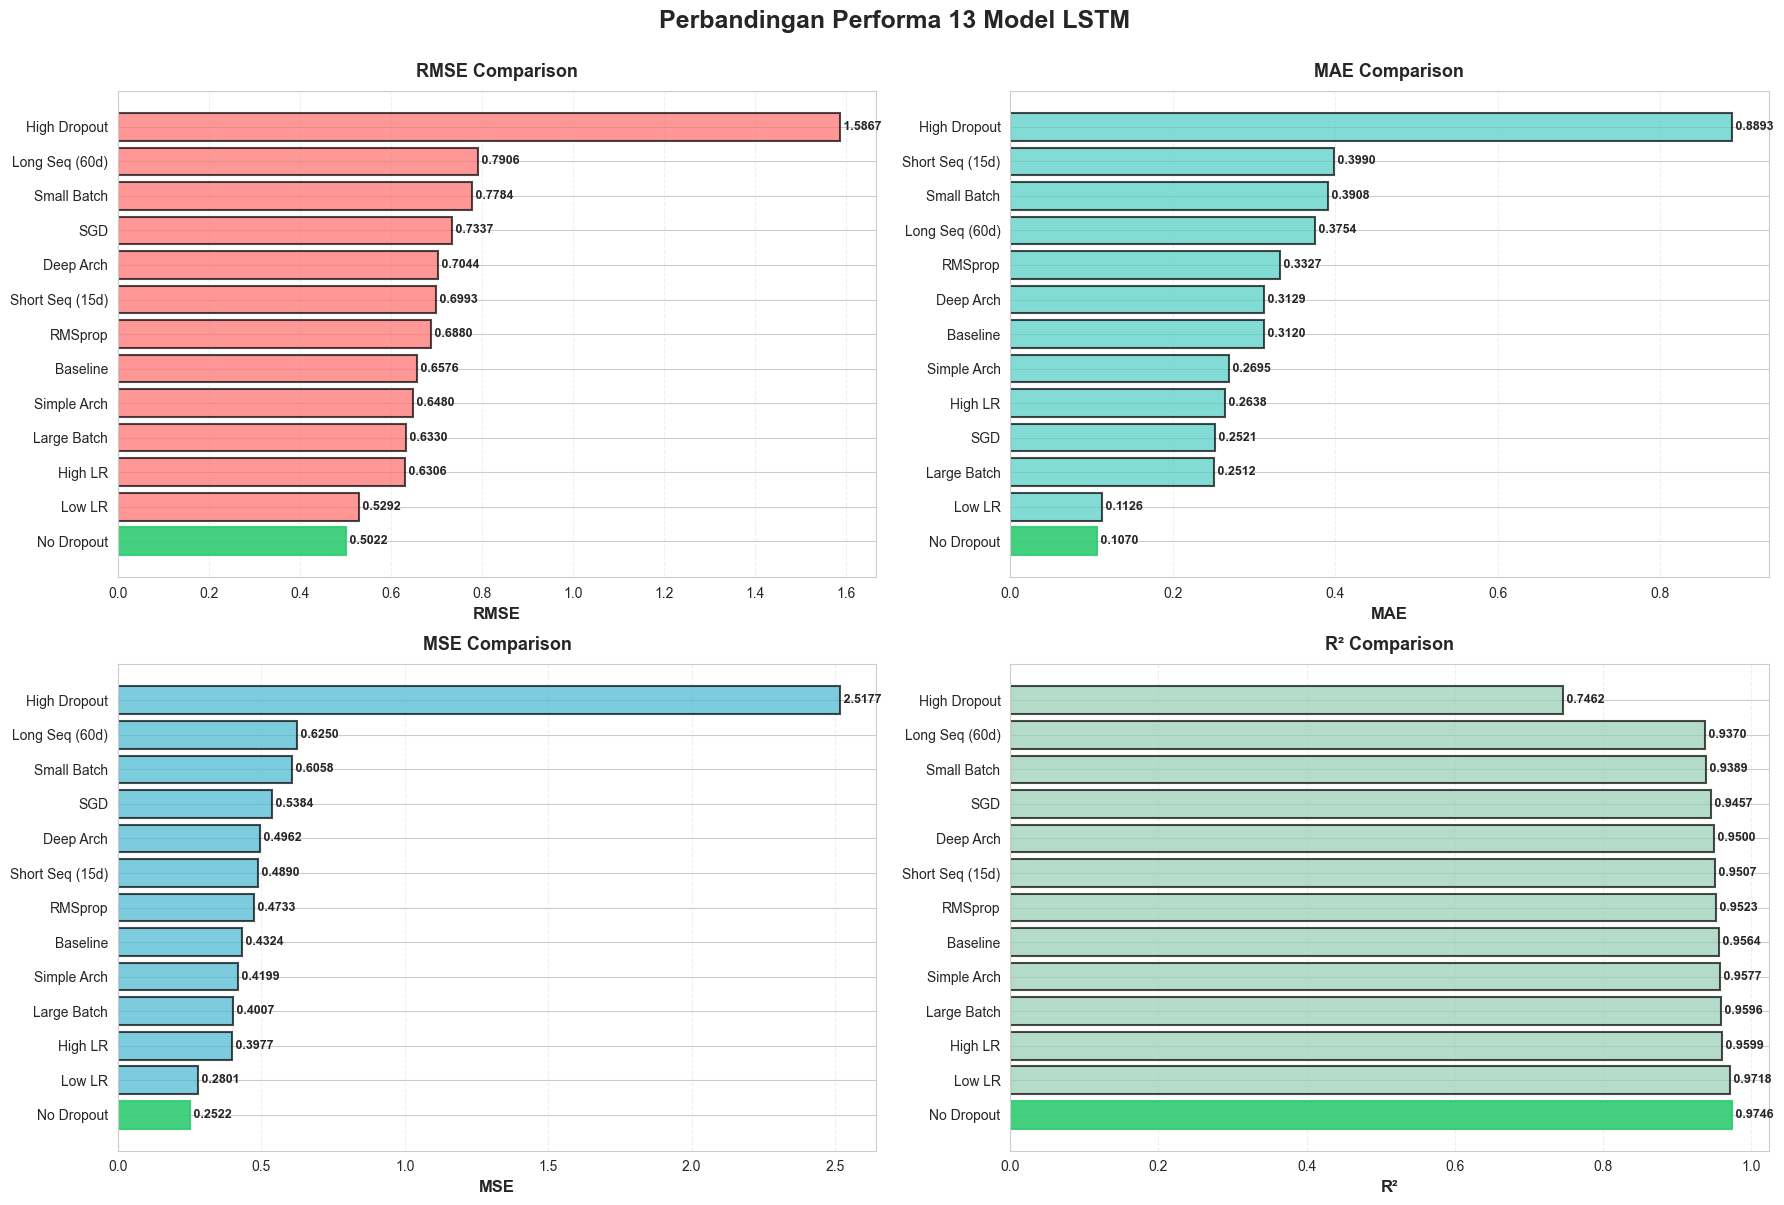

✓ Plots saved to 'model_comparison_plots.png'


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Perbandingan Performa 13 Model LSTM', fontsize=18, fontweight='bold', y=1.00)

metrics = ['RMSE', 'MAE', 'MSE', 'R²']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by metric
    if metric == 'R²':
        data = results_df.sort_values(metric, ascending=False)
    else:
        data = results_df.sort_values(metric)
    
    # Create bar plot
    bars = ax.barh(range(len(data)), data[metric], color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data['Model'], fontsize=10)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold', pad=10)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, data[metric])):
        ax.text(value, i, f' {value:.4f}', va='center', fontsize=9, fontweight='bold')
    
    # Highlight best model
    bars[0].set_color('#2ECC71')
    bars[0].set_alpha(0.9)

plt.tight_layout()
plt.savefig('model_comparison_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plots saved to 'model_comparison_plots.png'")

## 9. Visualisasi: Overall Ranking

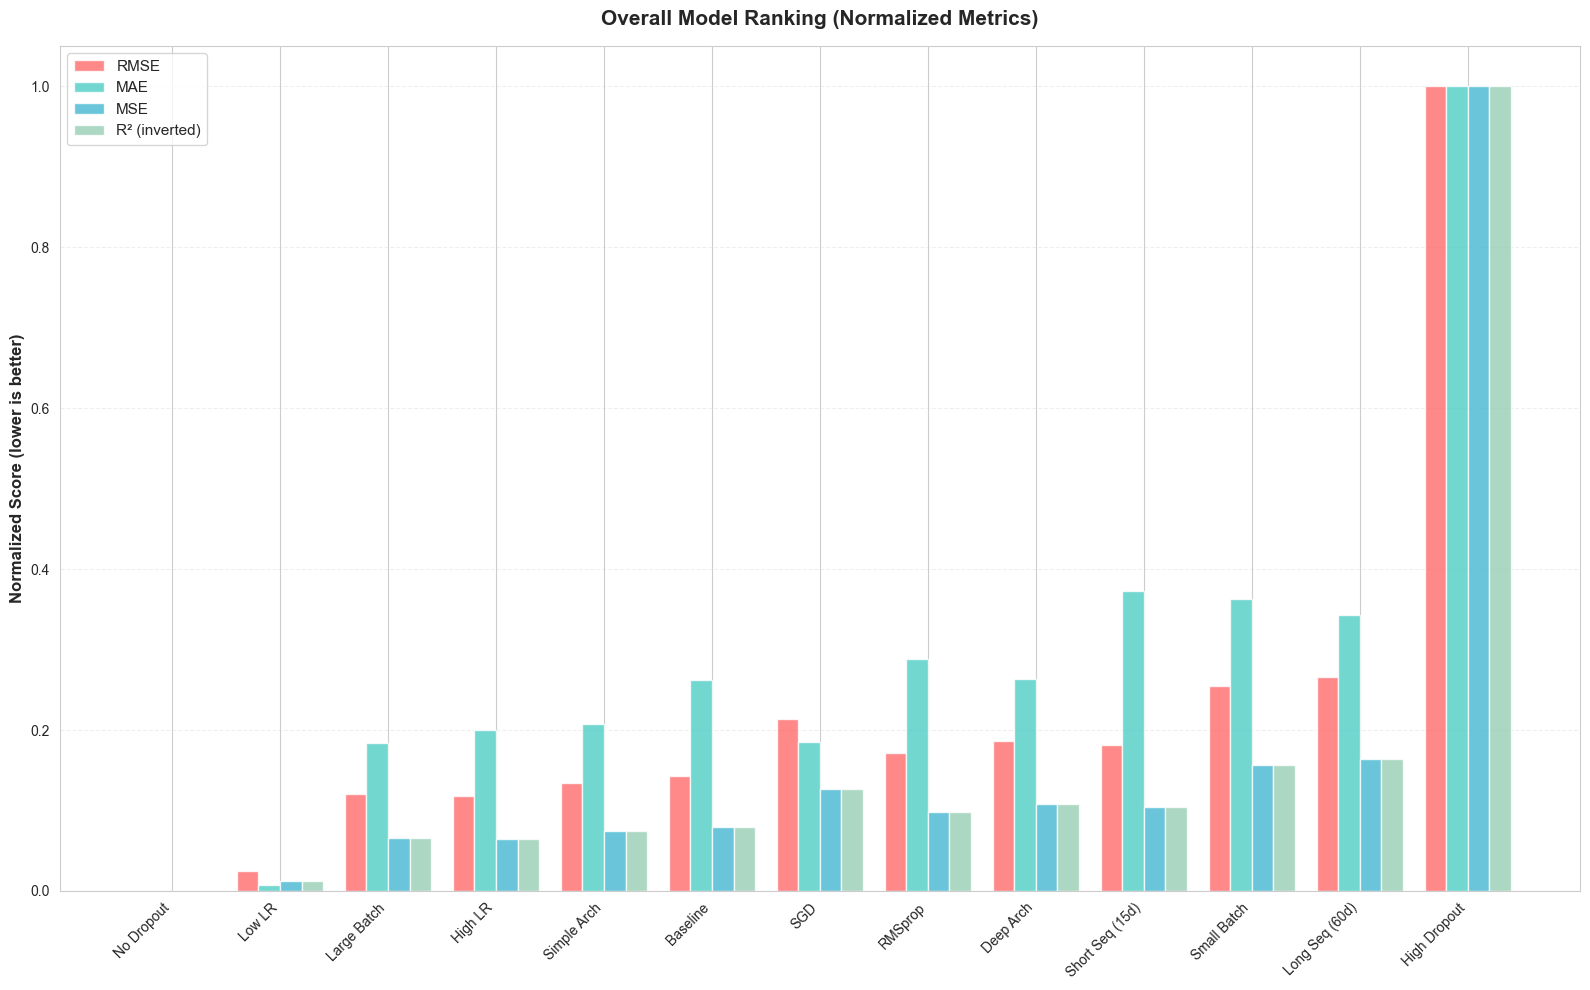

✓ Ranking plot saved to 'model_ranking.png'


In [9]:
fig, ax = plt.subplots(figsize=(16, 10))

# Normalize metrics untuk ranking
results_normalized = results_df.copy()
for metric in ['RMSE', 'MAE', 'MSE']:
    results_normalized[metric] = (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())
results_normalized['R²'] = (results_df['R²'].max() - results_df['R²']) / (results_df['R²'].max() - results_df['R²'].min())

# Calculate average rank
results_normalized['Avg_Score'] = results_normalized[['RMSE', 'MAE', 'MSE', 'R²']].mean(axis=1)
results_normalized = results_normalized.sort_values('Avg_Score')

# Plot
x = range(len(results_normalized))
width = 0.2

ax.bar([i - 1.5*width for i in x], results_normalized['RMSE'], width, label='RMSE', alpha=0.8, color='#FF6B6B')
ax.bar([i - 0.5*width for i in x], results_normalized['MAE'], width, label='MAE', alpha=0.8, color='#4ECDC4')
ax.bar([i + 0.5*width for i in x], results_normalized['MSE'], width, label='MSE', alpha=0.8, color='#45B7D1')
ax.bar([i + 1.5*width for i in x], results_normalized['R²'], width, label='R² (inverted)', alpha=0.8, color='#96CEB4')

ax.set_xticks(x)
ax.set_xticklabels(results_normalized['Model'], rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Normalized Score (lower is better)', fontsize=12, fontweight='bold')
ax.set_title('Overall Model Ranking (Normalized Metrics)', fontsize=15, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('model_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Ranking plot saved to 'model_ranking.png'")

## 10. Best Model Summary

In [10]:
print("\n" + "="*60)
print("🏆 BEST MODEL")
print("="*60)

best_model = results_df.iloc[0]
print(f"\nModel: {best_model['Model']}")
print(f"\nMetrics:")
print(f"  • RMSE: {best_model['RMSE']:.6f}")
print(f"  • MAE:  {best_model['MAE']:.6f}")
print(f"  • MSE:  {best_model['MSE']:.6f}")
print(f"  • R²:   {best_model['R²']:.6f}")

print("\n" + "="*60)
print("📊 TOP 3 MODELS")
print("="*60)
print(results_df.head(3).to_string(index=False))

print("\n" + "="*60)
print("📉 BOTTOM 3 MODELS")
print("="*60)
print(results_df.tail(3).to_string(index=False))

print("\n✅ Comparison completed successfully!")


🏆 BEST MODEL

Model: No Dropout

Metrics:
  • RMSE: 0.502168
  • MAE:  0.106950
  • MSE:  0.252173
  • R²:   0.974576

📊 TOP 3 MODELS
     Model      MSE     RMSE      MAE       R²
No Dropout 0.252173 0.502168 0.106950 0.974576
    Low LR 0.280062 0.529209 0.112614 0.971764
   High LR 0.397693 0.630629 0.263816 0.959904

📉 BOTTOM 3 MODELS
         Model      MSE     RMSE      MAE       R²
   Small Batch 0.605848 0.778363 0.390826 0.938918
Long Seq (60d) 0.624977 0.790555 0.375408 0.937024
  High Dropout 2.517743 1.586740 0.889334 0.746159

✅ Comparison completed successfully!


## 11. Statistical Analysis

In [11]:
print("\n" + "="*60)
print("📈 STATISTICAL SUMMARY")
print("="*60)

print("\nRMSE Statistics:")
print(f"  • Mean:   {results_df['RMSE'].mean():.6f}")
print(f"  • Median: {results_df['RMSE'].median():.6f}")
print(f"  • Std:    {results_df['RMSE'].std():.6f}")
print(f"  • Min:    {results_df['RMSE'].min():.6f}")
print(f"  • Max:    {results_df['RMSE'].max():.6f}")

print("\nR² Statistics:")
print(f"  • Mean:   {results_df['R²'].mean():.6f}")
print(f"  • Median: {results_df['R²'].median():.6f}")
print(f"  • Std:    {results_df['R²'].std():.6f}")
print(f"  • Min:    {results_df['R²'].min():.6f}")
print(f"  • Max:    {results_df['R²'].max():.6f}")

# Performance improvement
best_rmse = results_df['RMSE'].min()
worst_rmse = results_df['RMSE'].max()
improvement = ((worst_rmse - best_rmse) / worst_rmse) * 100

print(f"\n💡 Best model is {improvement:.2f}% better than worst model (RMSE)")


📈 STATISTICAL SUMMARY

RMSE Statistics:
  • Mean:   0.737047
  • Median: 0.687951
  • Std:    0.268673
  • Min:    0.502168
  • Max:    1.586740

R² Statistics:
  • Mean:   0.938514
  • Median: 0.952284
  • Std:    0.058821
  • Min:    0.746159
  • Max:    0.974576

💡 Best model is 68.35% better than worst model (RMSE)
